# My python codes


In [1]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import operator
from Levenshtein import *
import re
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline


In [42]:
#Preprocessing functions:



def stringConditionProcess(group, method = "first"):
    result = []
    for timeSeries in group:
        conditions = seriesContains(timeSeries, method)
        result.append(timeSeries[conditions])
    return result
        



def getEmptyEmotions():
    return {"joy":0,"sadness": 0,"fear":0, "anticipation": 0, "anger":0, "trust": 0, "disgust": 0 ,"surprise" : 0}

def getUsersEmotions(dbName,collectionName):
    collection = MongoClient("localhost", 27017)[dbName][collectionName]
    usersEmotions = {}
    for tweet in collection.find():
        userID = tweet["user"]["id"]
        emotion =  tweet["emotion"]["groups"][0]["name"]
        
        if len(tweet["emotion"]["groups"]) > 1:
            emotion_2 = tweet["emotion"]["groups"][1]["name"]
        else:
            emotion_2 = None
            
        date = tweet["created_at"]
        text = tweet['text']
        ambiguous = True if tweet['emotion']['ambiguous'] == 'yes' else False
        if userID not in usersEmotions:
            usersEmotions[userID] = {}
        if date not in usersEmotions[userID]:
            usersEmotions[userID][date] = getEmptyEmotions()
        usersEmotions[userID][date]['text'] = text
        usersEmotions[userID][date][emotion] += 1
        usersEmotions[userID][date]['ambiguous'] = ambiguous
        usersEmotions[userID][date]['emotion'] = emotion
        usersEmotions[userID][date]['emotion_2'] = emotion_2

    return usersEmotions


def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['pos'] = usersEmotions[userID]['joy'] + usersEmotions[userID]['trust'] 
        usersEmotions[userID]['neg'] = usersEmotions[userID]['fear'] + usersEmotions[userID]['sadness'] + usersEmotions[userID]['disgust'] + usersEmotions[userID]['anger']
        usersEmotions[userID]['polarity'] =  usersEmotions[userID]['pos'] - usersEmotions[userID]['neg']
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')

    return list(usersEmotions.values())


def disambiguate(timeSeries):
    conditions = np.logical_not(timeSeries['ambiguous'].values)
    timeSeries = timeSeries[conditions]
    timeSeries['dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries
        
def invalid_removal(data):
    data = np.array(data)
    return data[np.isfinite(data)]
    
def reject_outliers(data, m=2):
    data = np.array(data)
    data = data[np.isfinite(data)]
    return data[abs(data - np.mean(data)) < m * np.std(data)]        
        
        
    
    
    

In [3]:
#computation fumctions

def getAge(timeSeries):
    texts = ""
    for text in groups[0][0]["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_age(texts)

def getGender(timeSeries):
    texts = ""
    for text in groups[0][0]["text"].values:
        texts += text + "\n"
    return age_gender_predictor.get_gender(texts)
        

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result



def seriesContains(timeSeries,method ="first"):
    if method == "first":
        match_function = np.vectorize(firstPronuonDetect)
    elif method == "second":
        match_function = np.vectorize(secondPronuonDetect)
    elif method == "third":
            match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)
    


def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False
    
    
def secondPronuonDetect(words, matchers=["you"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False
    


def firstPronuonDetect(words, matchers=["i","we","i'd","i'm"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False
    



def getFlipsDurationMean(timeSeries, upperbound=np.inf, lowerbound=0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    durations = durations[np.isfinite(durations)]
    durations = durations[(durations > lowerbound) & (durations < upperbound)]
    return np.mean(durations)
    
    
    
def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries['dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values

def getConditionalFlip(timeSeries, emotion, counter_emotion):
    timeSeries['new_polarity'] = timeSeries[emotion] - timeSeries[counter_emotion]
    return getFlips(timeSeries,attribute='new_polarity')

def cleanPost(timeSeries):
    left_text = timeSeries['text'].values[:-1]
    right_text = timeSeries['text'].values[1:]
    conditions = np.logical_not(timeSeries['ambiguous'].values)
    edit_distance = np.vectorize(distance)
    conditions[:-1] =  conditions[:-1] & (edit_distance(left_text, right_text) > 5)
    patterns = ['http://','https://']
    
    for pattern in patterns:
        conditions = conditions & np.logical_not(timeSeries['text'].str.contains(pattern).values)
    timeSeries = timeSeries[conditions]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')

    return timeSeries

        
    


def userVerify(timeSeries, threshold = 0.5):
    http_rows = getHTTPRows(timeSeries)
    average_http_count = np.sum(http_rows) / timeSeries.shape[0]
    return (average_http_count < threshold) & (timeSeries.shape[0] > 50)
 

def groupFilter(group):
    new_group = []
    for timeSeries in group:
        if userVerify(timeSeries):
            new_group.append(timeSeries)
    return new_group


def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values
    
    

def getMeanDeltaTime(timeSeries, lowerbound=0, upperbound=3):
    delta_time = timeSeries['dt'][:-1].values
    mean_deal_time = np.mean(delta_time[(delta_time < upperbound) & (delta_time > lowerbound)])
    return mean_deal_time

def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips


def getTimeRange(timeSeries):
    time_range = (np.max(timeSeries.index.values) -np.min(timeSeries.index.values) ).astype('timedelta64[s]')
    time_range = time_range / np.timedelta64(60, 's')
    return time_range



def getPairs(timeSeries, upperbound = 0.2):
    conditions = timeSeries['dt'].values < upperbound
    conditions[1:] = conditions[1:] | conditions[:-1]
    return timeSeries[conditions]




In [4]:
#plotting functions

def agePlot(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    for g,group in enumerate(groups):
        ages = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            age = getAge(timeSeries)
            ages[i] = age
        plt.hist(ages,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('User Count')
        plt.xlabel('Age(years)')
        plt.title(legends[g])
        plt.show()
        print("Age mean:{0:2f} STD:{1:2f}".format(np.mean(ages),np.std(ages)))




def comboPlot(groups, bins=10,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    for g,group in enumerate(groups):
        tweets_length = np.zeros(len(group),dtype=int)
        combos = []
        for i,timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            combo = comboTracker(timeSeries)
            tweets_length[i] = timeSeries.shape[0]
            combos += [hit for element, hit in combo if element != 0 and hit >2 ]
        combos = reject_outliers(combos)
        plt.hist(combos,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(str(len(group)) + " "+legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(combos),np.std(combos)))



def emotionPieChart(groups,legends = ["BPD", "Normal"]):
    colorTable = {"joy":"#FADB4D","sadness": "#729DC9","fear":"#35A450", "anticipation": "#F2993A", "anger":"#E43054", "trust": "#99CC33", "disgust": "#9F78BA" ,"surprise" : "#3FA5C0"}
    emotions = ['surprise', 'fear', 'sadness', 'disgust', 'trust', 'anticipation', 'anger','joy']
    colors = [colorTable[emotion] for emotion in emotions]
    
    for g, group in enumerate(groups):
        emotion_means = {}
        for emotion in emotions:
            emotion_means[emotion] = [] 
        for timeSeries in group:
            if timeSeries.shape[0] < 100:
                continue
            timeSeries = cleanPost(timeSeries)
            summary = timeSeries.mean()
            for emotion in emotions:
                emotion_means[emotion].append(summary[emotion])
            
        for emotion in emotions:  
            emotion_means[emotion] = np.array(emotion_means[emotion])
            emotion_means[emotion] = emotion_means[emotion][np.isfinite(emotion_means[emotion])]

            
        emotion_means_np = [np.mean(emotion_means[emotion]) for emotion in emotions]
            
        #return emotion_means
        plt.title("{} people".format(legends[g]))
        plt.pie(emotion_means_np, labels=emotions, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
        plt.figure(figsize=(60,60))
        plt.show()
        #return emotion_means
        for emotion in emotions:
            print("{} std: {}".format(emotion, np.std(emotion_means[emotion])))

    
    
    
    


def flipDurationPlotPerUser(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Flip Durations of each flip")
    for g,group in enumerate(groups):
        delta_times = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            mean_deal_time = getFlipsDurationMean(timeSeries, lowerbound=0, upperbound=upperbound)
            delta_times[i] = mean_deal_time
        delta_times = delta_times[np.isfinite(delta_times)]
        plt.hist(delta_times,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title("{} {} people ".format(len(group),legends[g]))
        plt.show()
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))







def flipDurationPlot(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    for g,group in enumerate(groups):
        tweets_length = np.zeros(len(group),dtype=int)
        delta_times = np.array([])
        for i,timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            flips = getFlips(timeSeries)
            tweets_length[i] = timeSeries.shape[0]

            delta_times = np.concatenate((delta_times,getFlipsDuration(timeSeries, flips)))
        delta_times =delta_times[(delta_times < upperbound) & (delta_times > lowerbound)]
        plt.hist(delta_times,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(str(len(group)) + " "+legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))







def countPlotPerUser(groups,f, method="first", bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100, xmax=None):

        
    for g,group in enumerate(groups):
        counts = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            if method is None:
                http_count = f(timeSeries)
            else:

                http_count = f(timeSeries,method)
            average_count = np.sum(http_count) / timeSeries.shape[0]
            counts[i] =  average_count
    
        counts = counts[np.isfinite(counts)]
        
        plt.hist(counts,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('people')
        plt.xlabel('specific post / total post ')
        plt.title(str(len(group)) + " " + legends[g] + " people")
        if xmax is not None:
            axes = plt.gca()
            axes.set_xlim([0,xmax])
        plt.show()
        print("Mean:{0:2f} STD:{1:2f}".format(np.mean(counts),np.std(counts)))




def emotionCountPlotPerUser(groups,f, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    counter_emotions = {'joy':'sadness','anticipation':'surprise','anger':'fear','trust':'disgust'}
    for g,group in enumerate(groups):
        counts = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            http_count = 0
            for emotion, counter_emotion in counter_emotions.items():
                 http_count += np.sum(f(timeSeries,emotion,counter_emotion))
            average_count = http_count / timeSeries.shape[0]
            counts[i] =  average_count
        counts = counts[np.isfinite(counts)]
        plt.hist(counts,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(legends[g])
        plt.show()
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(counts),np.std(counts)))


        


def durationPlotPerUser(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    for g,group in enumerate(groups):
        delta_times = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            mean_deal_time = getMeanDeltaTime(timeSeries, upperbound=upperbound, lowerbound=lowerbound)
            delta_times[i] = mean_deal_time
        delta_times = delta_times[np.isfinite(delta_times)]
        plt.hist(delta_times,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(legends[g])
        plt.show()
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))

        
        
                
        


def durationPlot(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Duration of each tweets pair")
    for i,group in enumerate(groups):
        delta_times = np.array([])
        for timeSeries in group:
            timeSeries = cleanPost(timeSeries)
            delta_times = np.concatenate((delta_times,timeSeries['dt'][:-1].values))
        delta_times =delta_times[(delta_times < upperbound) & (delta_times > lowerbound)]
        plt.hist(delta_times,color=colors[i], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(legends[i])
        plt.show()
        
            



def polarityPlot(timeSeries, attribute = 'polarity'):
    fig, ax = plt.subplots()
    ax.set_ylabel("Sentiment Posts",  fontsize=14)
    ax.set_xlabel("Week",  fontsize=14)
    plt.plot(timeSeries[attribute])
    
    plt.axhline(y=0,linestyle="--", color="w")

    plt.show()
    
def peaksCount(timeSeries, attribute = 'polarity' ):
    middle = timeSeries[attribute][1:-1]
    left_elements = np.roll(timeSeries[attribute], 1)[1:-1]
    right_elements = np.roll(timeSeries[attribute], -1)[1:-1]
    local_maximum = (middle > left_elements) & (middle > right_elements)
    local_minimum = (middle < left_elements) & (middle < right_elements)
    return np.sum(local_maximum) , np.sum(local_minimum)

def crossingCount(timeSeries, attribute = 'polarity', n = 0):
    left_elements = np.roll(timeSeries[attribute], 1)[1:]
    right_elements = np.roll(timeSeries[attribute], -1)[:-1]
    positive_corssing = (left_elements < n) & (right_elements > n)
    negative_crossing = (left_elements > n) & (right_elements < n)
    return np.sum(positive_corssing | negative_crossing)





    

def foureirPlot(timeSeries):
    fig, ax = plt.subplots()
    ax.set_ylabel("Post",  fontsize=14)
    ax.set_xlabel("Time (Week as unit)",  fontsize=14)
    timeSeries['pos'].plot()
    plt.show()
    fig, ax = plt.subplots()
    ax.set_ylabel("Amplitude",  fontsize=14)
    ax.set_xlabel("Frequency (1/Week)",  fontsize=14)
    plt.plot(np.fft.rfftfreq(timeSeries['pos'].size), np.abs(np.fft.rfft(timeSeries['pos'])))
    plt.show()


def flipsPlot(groups, legends = ["BPD", "Normal"], colors =['red', 'green']):
    
    hist_results = []
    for i,group in enumerate(groups):
        group = groupFilter(group)
        hist_result = []
        flips_counts = []
        tweets_counts = []
        for timeSeries in group:
            flips = np.sum(getFlips(timeSeries))
            tweet_count = timeSeries['polarity'].shape[0]
            
            if np.isfinite(tweet_count) and tweet_count > 0:
                flips_per_post = flips / tweet_count

                hist_result.append(flips_per_post)
                flips_counts.append(flips)
                tweets_counts.append(tweet_count)
            
        
        hist_result = reject_outliers(hist_result)
        hist_results.append(hist_result)
        plt.title(legends[i])
        plt.xlabel("Flips per post")
        plt.hist(hist_result,color=colors[i], bins = 100, edgecolor='none')
        plt.show()
    
        print("Tweets Mean {0:.2f} ".format(np.mean(tweets_counts)))
        print("Flips Mean {0:.2f} ".format(np.mean(flips_counts)))

        print("Flips per post Mean {0:.2f}".format(np.mean(hist_result)))
        print("Flips per post Standard Deviation {0:.2f}".format(np.std(hist_result)))
    plt.hist(hist_results,color=colors, bins = 100, edgecolor='none', histtype='bar', normed=1, stacked=True)
   
    plt.xlabel("minutes")
    plt.show()

In [5]:
# statistics

def emotionAmbiguity(group, name):
    ambiguities = []
    for timeSeries in group:
        ambiguity = timeSeries.mean()['ambiguous']
        ambiguities.append(ambiguity)
    print("{} emotion ambiguity mean: {} std: {}".format(name, np.mean(ambiguities), np.std(ambiguities)))
        
        

In [49]:
#Fetching the data of BPD and random sampled Twitter user
BPDEmotions =  getUsersEmotions("patients","BPD_clean")
regular_Emotions =  getUsersEmotions("idea","regularUser_en_fixed_emotion")
bipolar_Emotions = getUsersEmotions("patients","bipolar_clean")
mix = getUsersEmotions("patients","bb_mix")
#Transform raw tweets into timeSeries data.
BPDtimeSeries = timeSeriesTransform(BPDEmotions) 
regular_timeSeries = timeSeriesTransform(regular_Emotions)
bipolar_timeSeries = timeSeriesTransform(bipolar_Emotions)
mix_timeSeries = timeSeriesTransform(mix)
#Filter and clean the timeSeries data
BPD_clean = groupFilter(BPDtimeSeries)
regular_clean = random.sample(groupFilter(regular_timeSeries), len(BPD_clean))
bipolar_clean = groupFilter(bipolar_timeSeries)
mix_clean = groupFilter(mix_timeSeries)


groups = [regular_clean,bipolar_clean, BPD_clean, mix_clean]
colors=['g','b', 'r','y']
legends = ["Normal", "Bipolar", "BPD","mix"]

Exception ignored in: <bound method Cursor.__del__ of <pymongo.cursor.Cursor object at 0x7f15c6061160>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.4/dist-packages/pymongo/cursor.py", line 218, in __del__
    self.__die()
  File "/usr/local/lib/python3.4/dist-packages/pymongo/cursor.py", line 283, in __die
    connection.close_cursor(self.__id)
  File "/usr/local/lib/python3.4/dist-packages/pymongo/mongo_client.py", line 1335, in close_cursor
    self.__cursor_manager.close(cursor_id)
  File "/usr/local/lib/python3.4/dist-packages/pymongo/cursor_manager.py", line 54, in close
    self.__connection().kill_cursors([cursor_id])
AttributeError: 'NoneType' object has no attribute 'kill_cursors'


In [46]:
#Let's visualize 

In [47]:
#The percentage of ambiguous emotion
emotionAmbiguity(BPD_clean, "BPD")
emotionAmbiguity(regular_clean, "Normal")
emotionAmbiguity(bipolar_clean, "Bipolar")
emotionAmbiguity(mix_clean, "Mix")

BPD emotion ambiguity mean: nan std: nan
Normal emotion ambiguity mean: nan std: nan
Bipolar emotion ambiguity mean: nan std: nan
Mix emotion ambiguity mean: 0.2811156188973661 std: 0.08628056549947087


/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


In [48]:
#Pie Chart of emotional distribution
emotionPieChart(groups, legends)


/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


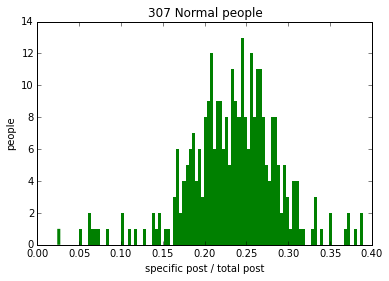

Mean:0.233813 STD:0.055810


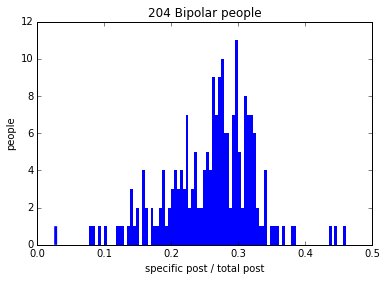

Mean:0.259433 STD:0.065498


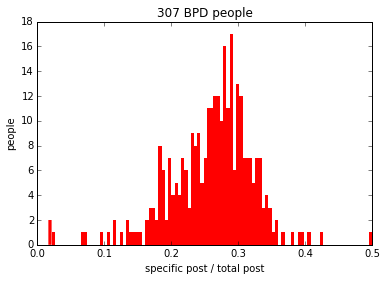

Mean:0.260548 STD:0.062817


In [37]:
#Positive emotion: Joy, Trust, Nagativeemotion: Anger, Disgust, Sadness, fear
#One emotional flip is two continous post with different emotional polarity
#The X-axis is the flips/all-tweets ratio, the Y-axis is users count

countPlotPerUser(groups, getFlips, method=None,colors=colors, legends=legends)

In [ ]:

#Emotion Wheel Flips
#This shit is too complicated, please ask GB for explaination#The X-axis is the flips/all-tweets ratio, the Y-axis is users count

emotionCountPlotPerUser(groups, getConditionalFlip,,colors=colors, legends=legends)

In [ ]:

durationPlotPerUser(groups, upperbound=3.5, bins=50,,colors=colors, legends=legends)


In [ ]:
#The X-axis is the time of one flip, the Y-axis is the flips count

flipDurationPlot(groups, bins=50,,colors=colors, legends=legends)

In [ ]:
#The X-axis is the average flip time of user , the Y-axis is the user count

flipDurationPlotPerUser(groups, bins=50, upperbound=40,,colors=colors, legends=legends)

In [ ]:
comboPlot(groups,,colors=colors, legends=legends)

In [ ]:
def getEmotionCount(timeSeries, matcher="fear"):
    return np.sum(timeSeries["emotion"].values == matcher)


In [ ]:
countPlotPerUser(groups,getEmotionCount , xmax=0.15,method=None,,colors=colors, legends=legends)   # Fear

In [ ]:
def getEmotionCount_anger(timeSeries, matcher="anger"):
    return np.sum(timeSeries["emotion"].values == matcher)
countPlotPerUser(groups,getEmotionCount_anger , xmax=0.35,method=None,colors=colors, legends=legends)   #Anger

In [ ]:
def getEmotionCount_sadness(timeSeries, matcher="sadness"):
    return np.sum(timeSeries["emotion"].values == matcher)
countPlotPerUser(groups,getEmotionCount_sadness ,xmax=0.9, method=None,colors=colors, legends=legends)   #sadness

In [ ]:
from nltk import PorterStemmer

def load_stopwords(file_location="../SmartStoplist"):
    f = open(file_location)
    stopwords = [line.strip() for line in f]
    return stopwords + ["http","https", "don", "thi","http ", "co","dont","im"]

stopwords = load_stopwords()
stemmer = PorterStemmer()
stopSet = set(stopwords)

def preprocessor(text):
    stemmer = PorterStemmer()
    words = []
    global stopSet
    
    for word in text.lower().split():
        word = re.sub('[!@#$?\'\"]|&amp', '',word)
        stemmedWord = stemmer.stem_word(word)
        condition_Word = word not in stopSet  and "http" not in word
        condition_StemmedWord = stemmedWord not in stopSet
        
        if  condition_Word and  condition_StemmedWord:
            words.append(stemmedWord)
    return " ".join(words)

def keywordsComparison(groups, emotion, n_feature = 10):
    tfidf = TfidfVectorizer(stop_words="english")
    group_texts = []
    total_texts = []
    for group in groups:
        texts = ""
        for timeSeries in group:
            conditions = timeSeries["emotion"].values == emotion
            timeSeries = timeSeries[conditions]
            text = preprocessor("\n".join(timeSeries["text"].values))
            texts += text
            total_texts.append(text)
        group_texts.append(texts)
        
       
    tfidf.fit(total_texts)
    word2vector = tfidf.get_feature_names()
    vectors = tfidf.transform(group_texts).todense()
    vectors = np.asarray(vectors)
    for vector in vectors:
        vector = np.argsort(vector)[::-1]
        for feature in vector[:n_feature:]:
            word = word2vector[feature]
            print(word)
        print("===========================\n")

       
    
    
    

In [ ]:
keywordsComparison(new_groups, "sadness", n_feature=30)

In [ ]:
keywordsComparison(new_groups, "fear", n_feature=30)

In [ ]:
np.asarray(x.todense()[0])

In [ ]:
x.get_feature_names()

In [ ]:
tdifd.fit